# Step 1. Load and prepare the dataset

In [2]:
import re
import nltk
import torch
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
from tqdm import tqdm
import pyLDAvis.gensim
from pprint import pprint
import torch.optim as optim
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gensim.corpora as corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
data = pd.read_csv('reddit_opinion_PSE_ISR.csv', quotechar='"', on_bad_lines='skip')

data = data.sample(frac=0.1)

data['post_text'] = data['post_title'] + ' ' + data['post_self_text']

# Drop rows with missing values
data.dropna(subset=['post_text', 'self_text', 'post_created_time', 'created_time', 'subreddit'], inplace=True)

# Remove unnecessary columns
data = data[['created_time', 'post_created_time', 'self_text', 'post_text']]
data.shape # (519925, 4) \/\/\ (104364, 4) \/\/\ (51955, 4)

(51955, 4)

# Step 2. VADER implementation

## 2.1 Get VADER sentiment labels

In [3]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Define function to get sentiment using VADER
def get_sentiment_vader(text):
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        return 'positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

data['self_text_vader'] = data['self_text'].apply(get_sentiment_vader)
data['post_text_vader'] = data['post_text'].apply(get_sentiment_vader)
data

,created_time,post_created_time,self_text,post_text,self_text_vader,post_text_vader
406427,2024-01-26 17:36:35,2024-01-26 16:56:00,Totally disagree with your analysis. I'd call...,ICJ court finds genocide risk https://www.reut...,positive,negative
82866,2024-03-26 22:48:20,2024-03-26 15:12:34,"Hamas, Isis. Both Islamist groups. The Quran? ...",Hot take: you are racist if you support either...,negative,positive
290910,2024-02-17 04:22:26,2024-02-16 22:23:45,Why am I not a refugee too. My family was dis...,The Saudi Tent City Could Serve as a Model for...,positive,positive
551216,2024-01-04 12:39:09,2024-01-04 10:04:31,If Israel uses nukes as a first strike I reall...,Nasrallah warns Israel of war 'with no rules’ ...,negative,negative
715574,2023-12-13 18:40:36,2023-12-13 13:51:18,"Hummm, what about a communist state but with s...","An independent Palestine, with love for Jewish...",neutral,positive
...,...,...,...,...,...,...
813467,2023-12-04 01:57:07,2023-12-03 12:16:34,I never thought i'd say I want to retire in a ...,What if the US did what Hamas did? Imagine the...,positive,negative
126033,2024-03-19 22:02:42,2024-03-19 19:54:31,You're kind of on a journey to no where. It's ...,Civilians Deaths in Gaza What I gather from th...,negative,negative
72115,2024-03-29 01:43:20,2024-03-27 21:48:30,Fuckin hope not Bernard Matthews will be out o...,Debunking the narrative that not enough aid is...,positive,positive
367051,2024-02-03 15:24:02,2024-02-03 15:06:54,I disagree that the attention needs to be dire...,everyone is mad at the wrong ‘other’ / influen...,negative,negative


## 2.2 Prepare the data

### 2.2.1 Load GloVe

In [4]:
def load_glove_embeddings(path):
    """
    Loads and reads GloVE file used to tokenize the sequences and help Classifier make better relations.
    """
    vocab = {}
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            vocab[word] = vector
    return vocab

glove_vocab = load_glove_embeddings('glove.twitter.27B.100d.txt')

### 2.2.2 Tokenize, encode and pad sequences

In [5]:
def tokenize_and_encode(texts, glove_vocab):
  """
  Uses GloVe vocabulary to tokenize and encode raw text.
  """
  tokenized_texts = [word_tokenize(text.lower()) for text in texts]
  encoded_texts = [[glove_vocab[word] if word in glove_vocab else np.random.rand(100) for word in tokens] for tokens in tokenized_texts]
  return encoded_texts

def pad_sequences(sequences, maxlen=100, default_value=0):
    """
    Adds necessary padding to the sequence, due to model constraints.
    """
    padded = np.zeros((len(sequences), maxlen, 100))
    for i, sequence in enumerate(sequences):
        if len(sequence) > 0:
            padded[i, :min(len(sequence), maxlen), :] = sequence[:maxlen]
        else:
            padded[i, :, :] = np.full((maxlen, 100), default_value)
    return padded

class TimeLabeledDataset(Dataset):
    """
    Dataset class to format input for Classifier.
    """
    def __init__(self, texts, labels, times):
        self.texts = texts
        self.labels = labels
        self.times = times

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx], self.times[idx]


# 0.1 post_text
texts_post = data['post_text'].tolist()
labels_post = data['post_text_vader'].tolist()
times_post = data['post_created_time'].tolist()

# 0.2 self_text
texts_self = data['self_text'].tolist()
labels_self = data['self_text_vader'].tolist()
times_self = data['created_time'].tolist()


# 1. Tokenize and encode
# 1.1. post_text
encoded_post_text = tokenize_and_encode(texts_post, glove_vocab)
empty_indices = [i for i, seq in enumerate(encoded_post_text) if len(seq) == 0]
#print("[POST]Empty sequences at indices:", empty_indices)

# 1.2 self_text
encoded_self_text = tokenize_and_encode(texts_self, glove_vocab)
empty_indices = [i for i, seq in enumerate(encoded_self_text) if len(seq) == 0]
#print("[SELF]Empty sequences at indices:", empty_indices)


# 2. Padding
# 2.1 post_text
padded_post_texts = pad_sequences(encoded_post_text)

# 2.2 self_text
padded_self_texts = pad_sequences(encoded_self_text)


# 3. Convert to tensors and split data
# 3.1 post_text
texts_post_tensor = torch.tensor(padded_post_texts, dtype=torch.float32)
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
labels_post = [label_mapping[label] for label in labels_post] # 3.1.1 Mapping labels to integers
labels_post_tensor = torch.tensor(labels_post, dtype=torch.long)
train_post_texts, test_post_texts, train_post_labels, test_post_labels = train_test_split(texts_post_tensor, labels_post_tensor, test_size=0.2, random_state=42)

# 3.2 self_text
texts_self_tensor = torch.tensor(padded_self_texts, dtype=torch.float32)
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
labels_self = [label_mapping[label] for label in labels_self] # 3.1.2 Mapping labels to integers
labels_self_tensor = torch.tensor(labels_self, dtype=torch.long)
labels_self_tensor = torch.tensor(labels_self, dtype=torch.long)
train_self_texts, test_self_texts, train_self_labels, test_self_labels = train_test_split(texts_self_tensor, labels_self_tensor, test_size=0.2, random_state=42)


# 4. Create datasets and dataloaders
# 4.1 post_text
data_post = TimeLabeledDataset(texts_post, labels_post, times_post)

train_post_data = TensorDataset(train_post_texts, train_post_labels)
test_post_data = TensorDataset(test_post_texts, test_post_labels)
train_post_loader = DataLoader(train_post_data, batch_size=64, shuffle=True)
test_post_loader = DataLoader(test_post_data, batch_size=64)

# 4.2 self_text
train_self_data = TensorDataset(train_self_texts, train_self_labels)
test_self_data = TensorDataset(test_self_texts, test_self_labels)
train_self_loader = DataLoader(train_self_data, batch_size=64, shuffle=True)
test_self_loader = DataLoader(test_self_data, batch_size=64)

## 2.3 Define the Classifier model

In [6]:
class SentimentClassifier(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.lstm = nn.LSTM(100, hidden_dim, batch_first=True)  # 100 for GloVe dim
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = hidden.squeeze(0)
        out = self.fc(hidden)
        return out

## 2.4 Train the model

In [7]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10, patience=3):
    best_valid_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation against
        model.eval()
        total_valid_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for texts, labels in test_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculation of metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        valid_loss = total_valid_loss / len(test_loader)
        print(f'Epoch {epoch+1}: Validation Loss: {valid_loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}')

        # Early Stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return all_labels, all_preds

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentClassifier(hidden_dim=64, output_dim=3)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss().to(device)

# 4. Train and evaluate
# 4.1 post_text
print("Training on post_text:")
real_post, pred_post = train_and_evaluate(model, train_post_loader, test_post_loader, optimizer, criterion, device)

# Resetting the model and optimizer
model = SentimentClassifier(hidden_dim=64, output_dim=3)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 4.2 self_text
print("\nTraining on self_text:")
real_self, pred_self = train_and_evaluate(model, train_self_loader, test_self_loader, optimizer, criterion, device)

Training on post_text:
Epoch 1: Validation Loss: 0.25778891054764846, Accuracy: 0.902800500433067, Precision: 0.9062492582406798, Recall: 0.902800500433067, F1-Score: 0.892157740601205
Epoch 2: Validation Loss: 0.15408034714087387, Accuracy: 0.9507265903185449, Precision: 0.9500600819902949, Recall: 0.9507265903185449, F1-Score: 0.9490812253316246
Epoch 3: Validation Loss: 0.11778238907662089, Accuracy: 0.9641035511500337, Precision: 0.963532055122377, Recall: 0.9641035511500337, F1-Score: 0.9637092278657697
Epoch 4: Validation Loss: 0.10980739869303041, Accuracy: 0.9700702531036474, Precision: 0.9697752135088121, Recall: 0.9700702531036474, F1-Score: 0.9698631844531095
Epoch 5: Validation Loss: 0.11027516195824816, Accuracy: 0.9721874699258974, Precision: 0.9720055178728303, Recall: 0.9721874699258974, F1-Score: 0.9719370977077099
Epoch 6: Validation Loss: 0.09920187085935492, Accuracy: 0.9747858723895679, Precision: 0.9747225200562948, Recall: 0.9747858723895679, F1-Score: 0.97474430

### 2.4.1 Evaluate predictions

In [9]:
pred_post = torch.tensor(pred_post)
real_post = torch.tensor(real_post)
pred_self = torch.tensor(pred_self)
real_self = torch.tensor(real_self)

post_correct = (pred_post == real_post).sum().item()
self_correct = (pred_self == real_self).sum().item()
post_acc = post_correct / real_post.size(0)
self_acc = self_correct / real_self.size(0)
print(f'post_text accuracy: {post_acc}\nself_text accuracy: {self_acc}')

#post_text accuracy: 0.9689154075642383
#self_text accuracy: 0.6886728900009623

post_text accuracy: 0.9689154075642383
self_text accuracy: 0.6886728900009623


## 2.5 Visualisation of VADER sentiment over time

In [25]:
data['created_time'] = pd.to_datetime(data['created_time'])
data['created_date'] = data['created_time'].dt.date # Extract true date

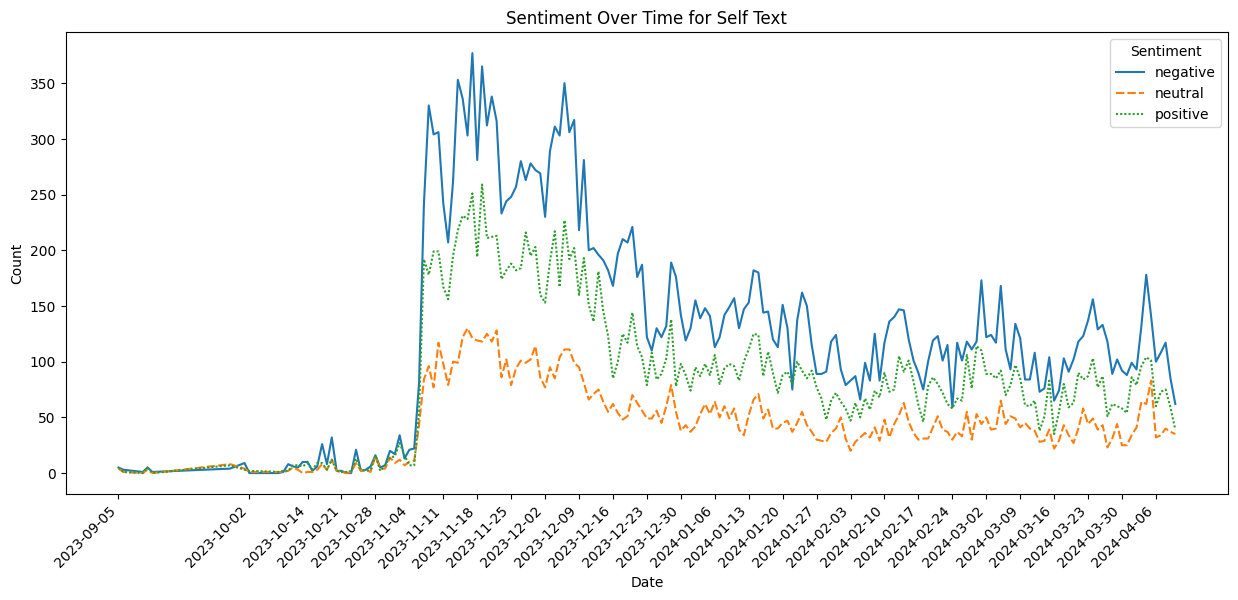

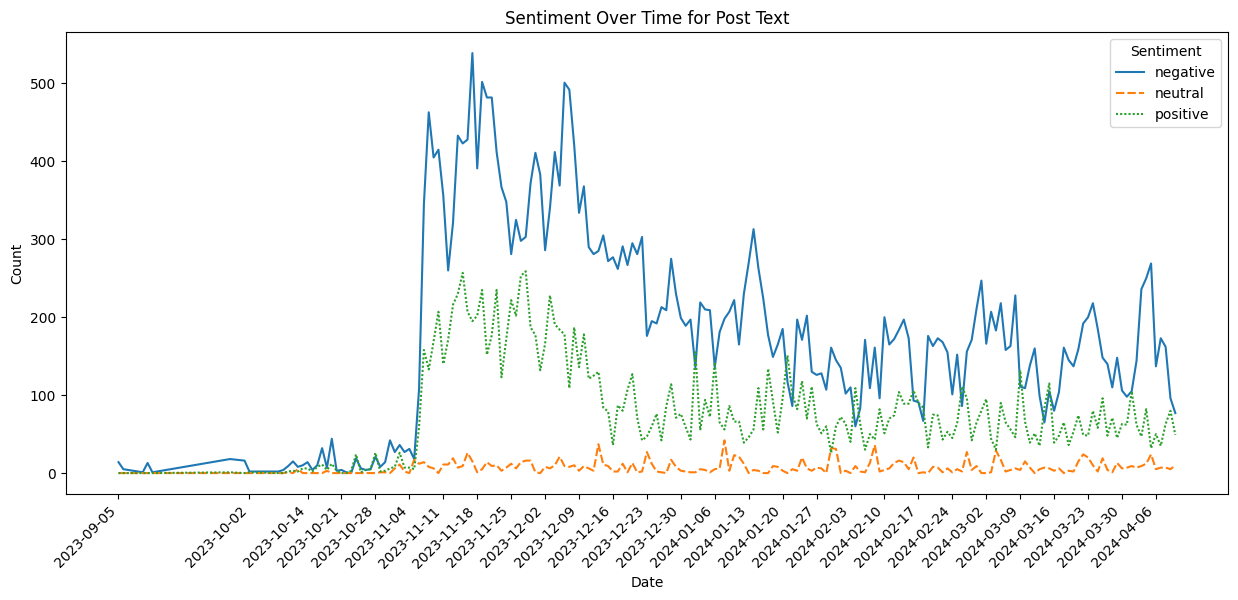

In [26]:
# 1. Convert sentiment scores to DataFrame
sentiment_over_time = pd.DataFrame(data[['created_time', 'self_text_vader', 'post_text_vader',]])

# 2. Plot sentiment over time 
# 2.1 self text
sentiment_counts_per_day_self = sentiment_over_time.groupby([sentiment_over_time['created_time'].dt.date, 'self_text_vader']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 6))
sns.lineplot(data=sentiment_counts_per_day_self, markers=False)  # Disable markers to use lines only

plt.title('VADER Sentiment Over Time for Self Text')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

ticks_to_show = sentiment_counts_per_day_self.index[::7]
plt.xticks(ticks_to_show, rotation=45, ha='right')
plt.show()


# 2.2 post text
sentiment_counts_per_day_post = sentiment_over_time.groupby([sentiment_over_time['created_time'].dt.date, 'post_text_vader']).size().unstack(fill_value=0)
plt.figure(figsize=(15, 6))
sns.lineplot(data=sentiment_counts_per_day_post, markers=False)  # Disable markers to use lines only

plt.title('VADER Sentiment Over Time for Post Text')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

ticks_to_show = sentiment_counts_per_day_post.index[::7]
plt.xticks(ticks_to_show, rotation=45, ha='right')
plt.show()

# Step 3. RoBERTa implementation

## 3.1 Preprocessing before RoBERTa input

In [27]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word.lower()) for word in filtered_tokens]
    # Join tokens back into text
    return ' '.join(lemmatized_tokens)

data['clean_self_text'] = data['self_text'].apply(preprocess_text)
data['clean_post_text'] = data['post_text'].apply(preprocess_text)
data

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mariatapia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariatapia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mariatapia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,created_time,post_created_time,self_text,post_text,self_text_vader,post_text_vader,created_date,clean_self_text,clean_post_text
406427,2024-01-26 17:36:35,2024-01-26 16:56:00,Totally disagree with your analysis. I'd call...,ICJ court finds genocide risk https://www.reut...,positive,negative,2024-01-26,totally disagree analysis id call win israel s...,icj court find genocide risk today icj ruled p...
82866,2024-03-26 22:48:20,2024-03-26 15:12:34,"Hamas, Isis. Both Islamist groups. The Quran? ...",Hot take: you are racist if you support either...,negative,positive,2024-03-26,hamas isi islamist group quran tell kill bow a...,hot take racist support either israel palestin...
290910,2024-02-17 04:22:26,2024-02-16 22:23:45,Why am I not a refugee too. My family was dis...,The Saudi Tent City Could Serve as a Model for...,positive,positive,2024-02-17,refugee family disposessed ethnically cleansed...,saudi tent city could serve model gaza refugee...
551216,2024-01-04 12:39:09,2024-01-04 10:04:31,If Israel uses nukes as a first strike I reall...,Nasrallah warns Israel of war 'with no rules’ ...,negative,negative,2024-01-04,israel us nuke first strike really dont think ...,nasrallah warns israel war rule whats next nas...
715574,2023-12-13 18:40:36,2023-12-13 13:51:18,"Hummm, what about a communist state but with s...","An independent Palestine, with love for Jewish...",neutral,positive,2023-12-13,hummm communist state sharia law new take old ...,independent palestine love jewish minority see...
...,...,...,...,...,...,...,...,...,...
813467,2023-12-04 01:57:07,2023-12-03 12:16:34,I never thought i'd say I want to retire in a ...,What if the US did what Hamas did? Imagine the...,positive,negative,2023-12-04,never thought id say want retire concentration...,u hamas imagine u sends soldier across border ...
126033,2024-03-19 22:02:42,2024-03-19 19:54:31,You're kind of on a journey to no where. It's ...,Civilians Deaths in Gaza What I gather from th...,negative,negative,2024-03-19,youre kind journey 100 dependent support pro i...,civilian death gaza gather debate distinction ...
72115,2024-03-29 01:43:20,2024-03-27 21:48:30,Fuckin hope not Bernard Matthews will be out o...,Debunking the narrative that not enough aid is...,positive,positive,2024-03-29,fuckin hope bernard matthew business love turk...,debunking narrative enough aid entering gaza p...
367051,2024-02-03 15:24:02,2024-02-03 15:06:54,I disagree that the attention needs to be dire...,everyone is mad at the wrong ‘other’ / influen...,negative,negative,2024-02-03,disagree attention need directed toengland 190...,everyone mad wrong influence survival cns trig...


## 3.2 Get RoBERTa sentiment labels

In [28]:
# 1. Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = RobertaForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment') # Twitter model is best when dealing with SM

# 2. Define Dataset class 
class TextDataset(Dataset):
    """
    Handles input for sentiment analysis.
    """
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

def create_dataloader(texts, tokenizer, batch_size=32):
    """
    Create DataLoader for sentiment analysis.
    """
    dataset = TextDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

def batch_encode(tokenizer, texts, max_length):
    """
    Encodes the text in given batch when getting sentiment labels.
    """
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")

def sentiment_analysis(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    results = []
    with torch.no_grad():
        for batch_texts in tqdm(dataloader, desc="Processing batches"):
            encoded_inputs = batch_encode(tokenizer, batch_texts, max_length=128)
            input_ids = encoded_inputs['input_ids'].to(model.device)
            attention_mask = encoded_inputs['attention_mask'].to(model.device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs[0]
            probabilities = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
            labels = [np.argmax(prob).item() for prob in probabilities]
            results.extend(labels)
    return results

# Create DataLoader
post = create_dataloader(data['clean_post_text'].tolist(), tokenizer, batch_size=32)
self = create_dataloader(data['clean_self_text'].tolist(), tokenizer, batch_size=32)

# Run sentiment analysis
post_sent = sentiment_analysis(model, post)
self_sent = sentiment_analysis(model, self)

# Map labels to sentiments
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
data['post_sentiment'] = [label_map[label] for label in post_sent]
data['self_sentiment'] = [label_map[label] for label in self_sent]

/opt/homebrew/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Processing batches: 100%|██████████| 1624/1624 [34:29<00:00,  1.27s/it]


## 3.3 Prepare the data

### 3.3.1 Load GloVe

In [29]:
def load_glove_embeddings(path):
    vocab = {}
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            vocab[word] = vector
    return vocab

glove_vocab = load_glove_embeddings('glove.twitter.27B.100d.txt')

### 3.3.2 Tokenise, encode and pad sequences

In [30]:
def tokenize_and_encode(texts, glove_vocab):
  """
  Uses GloVe vocabulary to tokenize and encode raw text.
  """
  tokenized_texts = [word_tokenize(text.lower()) for text in texts]
  encoded_texts = [[glove_vocab[word] if word in glove_vocab else np.random.rand(100) for word in tokens] for tokens in tokenized_texts]
  return encoded_texts

def pad_sequences(sequences, maxlen=100, default_value=0):
    padded = np.zeros((len(sequences), maxlen, 100))
    for i, sequence in enumerate(sequences):
        if len(sequence) > 0:
            padded[i, :min(len(sequence), maxlen), :] = sequence[:maxlen]
        else:
            padded[i, :, :] = np.full((maxlen, 100), default_value)
    return padded


# 0.1 post_text
texts_post = data['clean_post_text'].tolist()
labels_post = data['post_sentiment'].tolist()

# 0.2 self_text
texts_self = data['clean_self_text'].tolist()
labels_self = data['self_sentiment'].tolist()


# 1. Tokenize and encode
# 1.1. post_text
encoded_post_text = tokenize_and_encode(texts_post, glove_vocab)
empty_indices = [i for i, seq in enumerate(encoded_post_text) if len(seq) == 0]
#print("[POST]Empty sequences at indices:", empty_indices)

# 1.2 self_text
encoded_self_text = tokenize_and_encode(texts_self, glove_vocab)
empty_indices = [i for i, seq in enumerate(encoded_self_text) if len(seq) == 0]
#print("[SELF]Empty sequences at indices:", empty_indices)


# 2. Padding
# 2.1 post_text
padded_post_texts = pad_sequences(encoded_post_text)

# 2.2 self_text
padded_self_texts = pad_sequences(encoded_self_text)


# 3. Convert to tensors and split data
# 3.1 post_text
texts_post_tensor = torch.tensor(padded_post_texts, dtype=torch.float32)
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
labels_post = [label_mapping[label] for label in labels_post] # 3.1.1.Mapping labels to integers
labels_post_tensor = torch.tensor(labels_post, dtype=torch.long)
train_post_texts, test_post_texts, train_post_labels, test_post_labels = train_test_split(texts_post_tensor, labels_post_tensor, test_size=0.2, random_state=42)

# 3.2 self_text
texts_self_tensor = torch.tensor(padded_self_texts, dtype=torch.float32)
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
labels_self = [label_mapping[label] for label in labels_self] # 3.2.1.Mapping labels to integers
labels_self_tensor = torch.tensor(labels_self, dtype=torch.long)
labels_self_tensor = torch.tensor(labels_self, dtype=torch.long)
train_self_texts, test_self_texts, train_self_labels, test_self_labels = train_test_split(texts_self_tensor, labels_self_tensor, test_size=0.2, random_state=42)


# 4. Create datasets and dataloaders
# 4.1 post_text
train_post_data = TensorDataset(train_post_texts, train_post_labels)
test_post_data = TensorDataset(test_post_texts, test_post_labels)
train_post_loader = DataLoader(train_post_data, batch_size=64, shuffle=True)
test_post_loader = DataLoader(test_post_data, batch_size=64)

# 4.2 self_text
train_self_data = TensorDataset(train_self_texts, train_self_labels)
test_self_data = TensorDataset(test_self_texts, test_self_labels)
train_self_loader = DataLoader(train_self_data, batch_size=64, shuffle=True)
test_self_loader = DataLoader(test_self_data, batch_size=64)

[POST]Empty sequences at indices: []
[SELF]Empty sequences at indices: [91, 233, 306, 473, 609, 747, 886, 902, 1011, 1039, 1052, 1100, 1272, 1312, 1389, 1570, 1623, 1662, 1735, 1741, 1894, 1908, 1950, 1965, 2146, 2317, 2464, 2471, 2617, 2663, 2666, 2743, 2879, 2967, 3258, 3509, 3750, 3938, 3958, 3999, 4224, 4292, 4299, 4612, 4755, 4770, 5190, 5198, 5328, 5336, 5450, 5578, 5605, 5607, 5752, 5783, 5832, 5833, 5872, 5893, 5971, 5995, 6052, 6480, 6482, 6562, 6708, 6737, 6767, 7003, 7094, 7099, 7191, 7305, 7441, 7446, 7759, 7813, 7850, 8008, 8158, 8326, 8471, 8553, 8563, 8592, 8906, 8949, 8959, 9048, 9304, 9312, 9462, 9471, 9705, 9740, 9846, 9890, 9910, 9995, 10173, 10194, 10277, 10500, 10511, 10566, 10771, 10796, 10859, 10914, 11049, 11060, 11140, 11151, 11175, 11215, 11363, 11373, 11772, 11909, 11936, 12022, 12595, 12651, 12855, 12894, 13020, 13116, 13209, 13305, 13428, 13734, 13880, 14547, 14586, 14632, 14646, 14921, 14941, 15162, 15312, 15375, 15532, 16297, 16356, 16410, 16505, 16537, 1

## 3.4 Define and train LogisticRegression model

NOTE: We have discarded the use of LSTMClassifier as it has poorer results than LogisticRegression
- 0.61 vs 0.99
- 0.47 vs 0.66

In [33]:
# 0. Solution fit_transform problem
data['clean_self_text'].fillna('', inplace=True)
data['clean_post_text'].fillna('', inplace=True)

# 1. Split data
# 1.1 self_text
X_train_self, X_test_self, y_train_self, y_test_self = train_test_split(
    data['clean_self_text'], data['self_sentiment'], test_size=0.2, random_state=42)

# 1.2 post_text
X_train_post, X_test_post, y_train_post, y_test_post = train_test_split(
    data['clean_post_text'], data['post_sentiment'], test_size=0.2, random_state=42)


# 2. Vectorize text
# 2.1 self_text
vectorizer_self = CountVectorizer()
X_train_self = vectorizer_self.fit_transform(X_train_self)
X_test_self = vectorizer_self.transform(X_test_self)

# 2.2 post_text
vectorizer_post = CountVectorizer()
X_train_post = vectorizer_post.fit_transform(X_train_post)
X_test_post = vectorizer_post.transform(X_test_post)

# 3. Train model 
# 3.1 self_text
model_self = LogisticRegression()
model_self.fit(X_train_self, y_train_self)

# 3.2 post_text
model_post = LogisticRegression()
model_post.fit(X_train_post, y_train_post)


# 4. Predict and evaluate 
# 4.1 self_text 
predictions_clean_self = []
for i in tqdm(range(X_test_self.shape[0]), desc='Predicting clean_self_text'):
    predictions_clean_self.append(model_self.predict(X_test_self[i]))

self_rep = classification_report(y_test_self, predictions_clean_self, output_dict=True)


# 4.2 post_text
predictions_clean_post = []
for i in tqdm(range(X_test_post.shape[0]), desc='Predicting clean_post_text'):
    predictions_clean_post.append(model_post.predict(X_test_post[i]))

post_rep = classification_report(y_test_post, predictions_clean_post, output_dict=True)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

### 3.5.1 Evaluation

In [34]:
self_acc, post_acc = self_rep['accuracy'], post_rep['accuracy']

print(f'clean_post_text accuracy: {post_acc:.2f}')
print(f'clean_self_text accuracy: {self_acc:.2f}')

#clean_post_text accuracy: 0.99
#clean_self_text accuracy: 0.80

clean_post_text accuracy: 0.99
clean_self_text accuracy: 0.80


## 3.5 Visualisation of RoBERTa sentiment over time

In [35]:
data['created_time'] = pd.to_datetime(data['created_time'])

# Extract date from 'created_time'
data['created_date'] = data['created_time'].dt.date

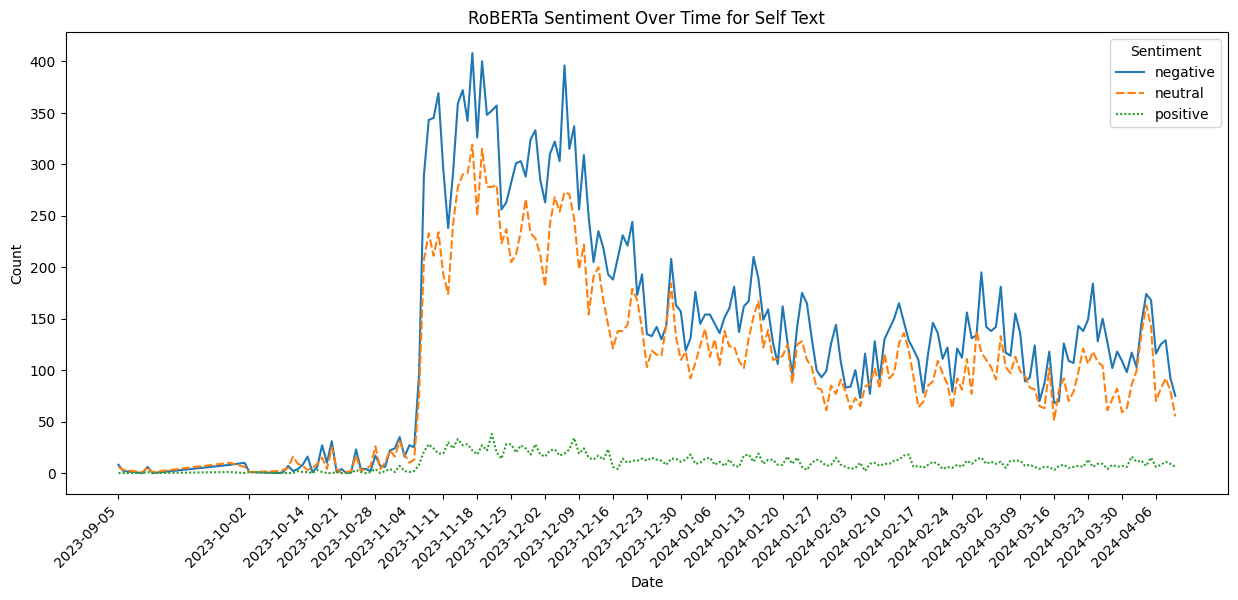

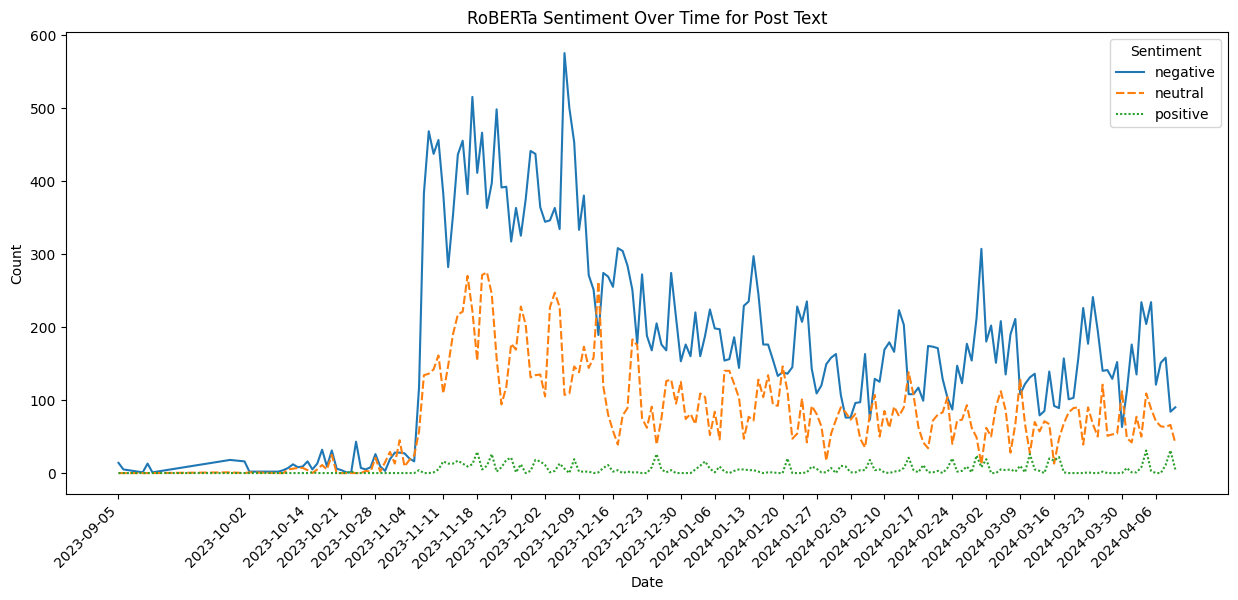

In [37]:
# Convert sentiment scores to DataFrame
sentiment_over_time = pd.DataFrame(data[['created_time', 'self_sentiment', 'post_sentiment',]])

# Plot sentiment over time for self text
# Group by 'created_time' and sentiment category, then calculate counts
sentiment_counts_per_day_self = sentiment_over_time.groupby([sentiment_over_time['created_time'].dt.date, 'self_sentiment']).size().unstack(fill_value=0)

# Plot sentiment over time for self text
plt.figure(figsize=(15, 6))

# Plot lines for each sentiment category
sns.lineplot(data=sentiment_counts_per_day_self, markers=False)  # Disable markers to use lines only

plt.title('RoBERTa Sentiment Over Time for Self Text')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

# Display every 7th date on x-axis
ticks_to_show = sentiment_counts_per_day_self.index[::7]
plt.xticks(ticks_to_show, rotation=45, ha='right')
plt.show()


# Plot sentiment over time for post text
# Group by 'created_time' and sentiment category, then calculate counts
sentiment_counts_per_day_post = sentiment_over_time.groupby([sentiment_over_time['created_time'].dt.date, 'post_sentiment']).size().unstack(fill_value=0)

# Plot sentiment over time for self text
plt.figure(figsize=(15, 6))

# Plot lines for each sentiment category
sns.lineplot(data=sentiment_counts_per_day_post, markers=False)  # Disable markers to use lines only

plt.title('RoBERTa Sentiment Over Time for Post Text')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

# Display every 7th date on x-axis
ticks_to_show = sentiment_counts_per_day_post.index[::7]
plt.xticks(ticks_to_show, rotation=45, ha='right')
plt.show()

# Step 4: Topic Modeling and Sentiment Analysis by Topic

## 4.1 Topic Modeling

In [38]:
# Tokenize function
def tokenize(text):
    # Split the text into tokens using regular expressions
    tokens = re.findall(r'\w+', text.lower())
    return tokens

# Load your dataset
# Assuming train_data is your DataFrame with 'clean_self_text' and 'clean_post_text' columns
# If it's not already loaded, you can load it here

# Tokenize 'clean_self_text' and 'clean_post_text' columns
data['tokenized_self_text'] = data['clean_self_text'].apply(tokenize)
data['tokenized_post_text'] = data['clean_post_text'].apply(tokenize)

# Create Dictionary for self text
id2word_self_text = corpora.Dictionary(data['tokenized_self_text'])

# Create Corpus for self text
corpus_self_text = [id2word_self_text.doc2bow(text) for text in data['tokenized_self_text']]

# Create Dictionary for post text
id2word_post_text = corpora.Dictionary(data['tokenized_post_text'])

# Create Corpus for post text
corpus_post_text = [id2word_post_text.doc2bow(text) for text in data['tokenized_post_text']]

# Train LDA model with 5 topics
num_topics = 3
lda_model_self_text = LdaModel(corpus=corpus_self_text,
                                id2word=id2word_self_text,
                                num_topics=num_topics, 
                                random_state=100,
                                update_every=1,
                                chunksize=100,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)

lda_model_post_text = LdaModel(corpus=corpus_post_text,
                                id2word=id2word_post_text,
                                num_topics=num_topics, 
                                random_state=100,
                                update_every=1,
                                chunksize=100,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)



In [39]:
# Print the keywords of topics for self text
pprint(lda_model_self_text.print_topics(num_topics=num_topics, num_words=5)[1])

# Print the keywords of topics for post text
pprint(lda_model_post_text.print_topics(num_topics=num_topics, num_words=5)[1])

(1,
 '0.021*"people" + 0.014*"dont" + 0.012*"like" + 0.010*"think" + 0.009*"one"')
(1,
 '0.022*"hamas" + 0.018*"gaza" + 0.015*"israel" + 0.013*"civilian" + '
 '0.009*"idf"')


In [40]:
# Get topics for self text
topics_self_text = lda_model_self_text.get_document_topics(corpus_self_text)

# Get topics for post text
topics_post_text = lda_model_post_text.get_document_topics(corpus_post_text)

# Store topic numbers in DataFrame
data['topic_self_text'] = [max(topic, key=lambda x: x[1])[0] for topic in topics_self_text]
data['topic_post_text'] = [max(topic, key=lambda x: x[1])[0] for topic in topics_post_text]

# Print the DataFrame to verify the stored topics
#print(train_data[['topic_self_text', 'topic_post_text']])


In [ ]:
# Visualize the topics in LDA for self text
pyLDAvis.enable_notebook()
vis_self_text = pyLDAvis.gensim.prepare(lda_model_self_text, corpus_self_text, id2word_self_text)
vis_self_text

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.280553  0.059864       1        1  48.634157
0      0.081023 -0.242516       2        1  27.154158
2      0.199529  0.182652       3        1  24.211684, topic_info=            Term           Freq          Total Category  logprob  loglift
112        hamas  106281.000000  106281.000000  Default  30.0000  30.0000
119          jew   72559.000000   72559.000000  Default  29.0000  29.0000
117       israel  189876.000000  189876.000000  Default  28.0000  28.0000
92          gaza   55053.000000   55053.000000  Default  27.0000  27.0000
144  palestinian  110909.000000  110909.000000  Default  26.0000  26.0000
..           ...            ...            ...      ...      ...      ...
228        would   17332.928697   71231.892140   Topic3  -5.0221   0.0050
144  palestinian   20082.248240  110909.611973   Topic3  -4.8748  -0.2905
581     genocide   10870.931738   23601.833544   Topic3  -5.4886   0.6431
29          also   10737.554765   42676.330030   Topic3  -5.5009   0.0384
351         year   10022.411323   30163.949307   Topic3  -5.5699   0.3165

[176 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
949       2  0.999811     1948
440       3  0.999870        7
2012      3  0.999919      7th
1518      3  0.999893      aid
29        1  0.457842     also
...     ...       ...      ...
351       3  0.332251     year
195       1  0.999985    youre
521       2  0.999883  zionism
337       1  0.385404  zionist
337       2  0.614566  zionist

[196 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [50]:
# Get the top tokens for topic 1 with their probabilities
topic_tokens = lda_model_self_text.show_topic(2, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset
    
    sentiment = data[data['tokenized_self_text'].apply(lambda x: token in x)]['self_sentiment'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')

Token: hamas, Probability: 0.04981780797243118, Sentiment: negative
Token: civilian, Probability: 0.021937793120741844, Sentiment: negative
Token: gaza, Probability: 0.021155014634132385, Sentiment: negative
Token: war, Probability: 0.01676979847252369, Sentiment: negative
Token: terrorist, Probability: 0.011937687173485756, Sentiment: negative
Token: idf, Probability: 0.011759672313928604, Sentiment: negative
Token: child, Probability: 0.010187344625592232, Sentiment: negative
Token: attack, Probability: 0.009145263582468033, Sentiment: negative
Token: killed, Probability: 0.008448204956948757, Sentiment: negative
Token: military, Probability: 0.008446156047284603, Sentiment: negative
Token: death, Probability: 0.008288663811981678, Sentiment: neutral
Token: killing, Probability: 0.007999268360435963, Sentiment: negative
Token: israeli, Probability: 0.007888838648796082, Sentiment: negative
Token: crime, Probability: 0.007280215620994568, Sentiment: negative
Token: number, Probability

In [51]:
# Get the top tokens for topic 1 with their probabilities
topic_tokens = lda_model_self_text.show_topic(1, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset
    sentiment = data[data['tokenized_self_text'].apply(lambda x: token in x)]['self_sentiment'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')

Token: people, Probability: 0.020896047353744507, Sentiment: negative
Token: dont, Probability: 0.014047820121049881, Sentiment: negative
Token: like, Probability: 0.012301601469516754, Sentiment: neutral
Token: think, Probability: 0.009541966952383518, Sentiment: negative
Token: one, Probability: 0.009140023961663246, Sentiment: negative
Token: would, Probability: 0.009083746001124382, Sentiment: negative
Token: know, Probability: 0.007200616877526045, Sentiment: negative
Token: im, Probability: 0.007050448562949896, Sentiment: negative
Token: even, Probability: 0.006939967628568411, Sentiment: neutral
Token: say, Probability: 0.006759192794561386, Sentiment: neutral
Token: thats, Probability: 0.006273819133639336, Sentiment: neutral
Token: u, Probability: 0.006264588795602322, Sentiment: negative
Token: thing, Probability: 0.005756590515375137, Sentiment: neutral
Token: get, Probability: 0.005587717052549124, Sentiment: neutral
Token: want, Probability: 0.005495158489793539, Sentimen

In [52]:
# Get the top tokens for topic 0 with their probabilities
topic_tokens = lda_model_self_text.show_topic(0, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset
    
    sentiment = data[data['tokenized_self_text'].apply(lambda x: token in x)]['self_sentiment'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')

Token: israel, Probability: 0.05065859109163284, Sentiment: negative
Token: palestinian, Probability: 0.03013060986995697, Sentiment: negative
Token: jew, Probability: 0.02242615818977356, Sentiment: negative
Token: state, Probability: 0.013309801928699017, Sentiment: negative
Token: arab, Probability: 0.013158092275261879, Sentiment: negative
Token: country, Probability: 0.01238514669239521, Sentiment: negative
Token: land, Probability: 0.010744051076471806, Sentiment: negative
Token: jewish, Probability: 0.010272258892655373, Sentiment: neutral
Token: israeli, Probability: 0.008614561520516872, Sentiment: negative
Token: palestine, Probability: 0.008281000889837742, Sentiment: neutral
Token: war, Probability: 0.007626681588590145, Sentiment: negative
Token: year, Probability: 0.0076063466258347034, Sentiment: neutral
Token: right, Probability: 0.00710078002884984, Sentiment: negative
Token: peace, Probability: 0.005782825406640768, Sentiment: neutral
Token: government, Probability: 0

## [Note] Description of topics
Topic 0: Pro Israel

This topic exhibits a sentiment largely positive towards Israel, as indicated by the presence of words like "Israel," "Jew," "State," and "Israeli" with positive sentiment probabilities.
Additionally, terms like "Peace" suggest a favorable viewpoint towards efforts for peace in the region.
While terms like "Muslim" and "War" have negative sentiment probabilities, they are outweighed by the overall positive sentiment towards Israel.

Topic 1: Neutral

This topic does not exhibit a clear bias towards either side of the conflict.
Terms like "People," "Think," "One," and "Would" are generic and do not lean towards any specific stance.
While some terms like "Im" and "Say" have negative sentiment probabilities, the overall tone of the topic remains balanced and nonpartisan.

Topic 2: Pro Palestine

This topic demonstrates a sentiment largely positive towards Palestine, evident from terms such as "Hamas," "Gaza," and "Palestinian" with positive sentiment probabilities.
Words like "Attack" and "Child" suggest empathy towards Palestinian suffering.
Negative sentiment probabilities associated with terms like "War," "Civilian," and "Military" reinforce a viewpoint sympathetic towards Palestinian interests, despite the inclusion of terms like "Israeli" and "IDF."
By analyzing the sentiment probabilities and thematic alignment of each topic, Topic 0 is categorized as "Pro Israel," Topic 1 as "Neutral," and Topic 2 as "Pro Palestine."

In [49]:
import pyLDAvis.gensim
# Visualize the topics in LDA for post text
vis_post_text = pyLDAvis.gensim.prepare(lda_model_post_text, corpus_post_text, id2word_post_text)
vis_post_text

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.042006 -0.144385       1        1  44.903818
0     -0.134649  0.101416       2        1  27.848839
1      0.176655  0.042969       3        1  27.247344, topic_info=          Term          Freq         Total Category  logprob  loglift
66       hamas  91508.000000  91508.000000  Default  30.0000  30.0000
230        jew  55737.000000  55737.000000  Default  29.0000  29.0000
315   civilian  35221.000000  35221.000000  Default  28.0000  28.0000
1111      arab  31182.000000  31182.000000  Default  27.0000  27.0000
253      state  41178.000000  41178.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
181      would   9108.651098  49962.147313   Topic3  -5.5467  -0.4018
9         also   7674.570194  27231.471280   Topic3  -5.7180   0.0338
111        one   8370.382652  42165.317389   Topic3  -5.6

In [1]:
# Get the top tokens for topic 2 with their probabilities
topic_tokens = lda_model_post_text.show_topic(2, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset
   
    sentiment = data[data['tokenized_post_text'].apply(lambda x: token in x)]['post_sentiment'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')


NameError: name 'lda_model_post_text' is not defined

In [47]:
# Get the top tokens for topic 1 with their probabilities
topic_tokens = lda_model_post_text.show_topic(1, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset
   
    sentiment = data[data['tokenized_post_text'].apply(lambda x: token in x)]['post_sentiment'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')


Token: hamas, Probability: 0.021705957129597664, Sentiment: negative
Token: gaza, Probability: 0.01816842332482338, Sentiment: negative
Token: israel, Probability: 0.01541383471339941, Sentiment: negative
Token: civilian, Probability: 0.012708062306046486, Sentiment: positive
Token: idf, Probability: 0.009134323336184025, Sentiment: negative
Token: israeli, Probability: 0.00871321465820074, Sentiment: negative
Token: genocide, Probability: 0.007207365706562996, Sentiment: negative
Token: war, Probability: 0.006131509784609079, Sentiment: positive
Token: palestinian, Probability: 0.005553613416850567, Sentiment: negative
Token: death, Probability: 0.005342818796634674, Sentiment: negative
Token: killed, Probability: 0.0052209170535206795, Sentiment: negative
Token: military, Probability: 0.005042540840804577, Sentiment: positive
Token: child, Probability: 0.004938625264912844, Sentiment: neutral
Token: hostage, Probability: 0.004757643211632967, Sentiment: positive
Token: attack, Probab

In [48]:
# Get the top tokens for topic 0 with their probabilities
topic_tokens = lda_model_post_text.show_topic(0, topn=20)

# Sort the tokens by probability in descending order
topic_tokens_sorted = sorted(topic_tokens, key=lambda x: x[1], reverse=True)

# Print the tokens, their probabilities, and sentiments
for token, prob in topic_tokens_sorted:
    # Retrieve the sentiment information for the token from your dataset
   
    sentiment = data[data['tokenized_post_text'].apply(lambda x: token in x)]['post_sentiment'].values[0]
    # Print the token, its probability, and sentiment
    print(f'Token: {token}, Probability: {prob}, Sentiment: {sentiment}')


Token: israel, Probability: 0.025423213839530945, Sentiment: negative
Token: palestinian, Probability: 0.02261807769536972, Sentiment: negative
Token: jew, Probability: 0.015222595073282719, Sentiment: positive
Token: state, Probability: 0.014231856912374496, Sentiment: positive
Token: arab, Probability: 0.011804038658738136, Sentiment: positive
Token: land, Probability: 0.009153995662927628, Sentiment: positive
Token: jewish, Probability: 0.008343846537172794, Sentiment: positive
Token: palestine, Probability: 0.008289027959108353, Sentiment: negative
Token: israeli, Probability: 0.0073970286175608635, Sentiment: negative
Token: would, Probability: 0.006577988155186176, Sentiment: negative
Token: country, Probability: 0.006417437922209501, Sentiment: negative
Token: people, Probability: 0.006202128250151873, Sentiment: negative
Token: right, Probability: 0.005838728975504637, Sentiment: positive
Token: west, Probability: 0.005765396635979414, Sentiment: neutral
Token: bank, Probabilit

[NOTE] Description of topics

Based on the top 20 frequent words, their probabilities, and sentiments, here are the topics found:

1. **Pro Israel**: Topic 1
2. **Pro Palestine**: Topic 2
3. **Neutral**: Topic 0
:

- Topic 1 (Pro Israel): This topic prominently features terms like "Israel," "Israeli," "Jew," "State," and "Peace." The sentiment associated with these terms is mostly positive. It discusses aspects related to Israel, its people, and potential solutions for peace, aligning with a perspective favoring Israel.

- Topic 2 (Pro Palestine): Terms like "Hamas," "Gaza," "Palestinian," "Genocide," and "War" dominate this topic. The sentiment associated with many of these terms is negative, highlighting issues such as war, civilian casualties, and conflict, which are often associated with a pro-Palestine stance.

- Topic 0 (Neutral): This topic contains terms such as "Palestinian," "Arab," "Solution," and "War," with sentiments varying between positive and negative. It presents a mix of terms associated with both sides of the conflict but doesn't strongly lean towards either, suggesting a neutral stance.

Therefore, Topic 1 is labeled as Pro Israel, Topic 2 as Pro Palestine, and Topic 0 as Neutral.

## 4.2 Visualise sentiment distribution withtin each topic

In [53]:
# Plot sentiment distribution within each topic for self text
plt.figure(figsize=(12, 6))
sns.countplot(x='topic_self_text', hue='self_sentiment', data=data)
plt.title('Sentiment Distribution Within Each Topic for Self Text')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=[topic_names_self_text[0], topic_names_self_text[1], topic_names_self_text[2]])
plt.legend(title='Sentiment')
plt.show()

# Plot sentiment distribution within each topic for post text
plt.figure(figsize=(12, 6))
sns.countplot(x='topic_post_text', hue='post_sentiment', data=train_data)
plt.title('Sentiment Distribution Within Each Topic for Post Text')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=[topic_names_post_text[0], topic_names_post_text[1], topic_names_post_text[2]])
plt.legend(title='Sentiment')
plt.show()

NameError: name 'train_data' is not defined

<Figure size 1200x600 with 0 Axes>